For this notebook you need to install:

- `tensorflow`
- `keras`
- `keras-vis`

The easiest way is to first install the `anaconda` distribution for `python` (preferably `Python 3`) and then use in a terminal

    conda install pip
 
`pip` is the python package installation tool. Then, you can simply use

    pip install tensorflow
    pip install keras
    pip install keras-vis

which should install everything easily.

The `numpy` library does some expensive operations outside Python using efficient code (Fortran, C/C++). However, switching back to python after each operation cause a big overhead because of unnecessary copies of the data. 

The library `tensorflow` does all the computations outside of Python: the python API is used to define a graph of operations, that will run entirely using C++ binaries. This architecture allows to get rid of the overhead. Besides, knowing the computational graph beforehand allows to parallelize and/or distribute the computation more easily. As a result, `tensoflow` can run the computations on multiple CPUs or GPUs, and on multiple servers.

However, for quick an easy model prototying, the library `keras` is simpler to use than `tensorflow`. 
Deep learning models can be constructed thanks to `keras` in few lines of python. So in this notebook, we won't see direct calls to `tensorflow`, but only to `keras`, even if the computations are done by `tensorflow`.

In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



import pickle as pkl

import tensorflow
import keras
from keras import optimizers
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import warnings
warnings.filterwarnings("ignore")
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
KFold

print("tensorflow version %s (should be at least 0.12.1)" % tensorflow.__version__)
print("keras version %s (should be at least 2.0.7)" % keras.__version__)

### <font color=darkred> Handwritten digit recognition with MNIST</font>

For the first part of this tutorial, we will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset.
This dataset contains images representing handwritten digits. 
Each image is 28 x 28 pixels, and each pixel is represented by a number (gray level). 
These arrays can be flattened into vectors of 28 x 28 = 784 numbers.
You can then see each image as a point in a 784-dimensional vector space. 
You can find interesting visualisations of this vector space [http://colah.github.io/posts/2014-10-Visualizing-MNIST/](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

The labels in $\{0, 1, 2, \ldots, 9\}$ giving the digit on the image are be represented using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

Also, MNIST data is grayscale pixels in $\{0, \ldots, 255\}$. The pixels should be normalized to belong to $[0, 1]$.
Indeed, working with big floats can lead to important numerical errors, in particular in deep learning models.

MNIST is a very old and standard benchmark dataset for image classification, so it's built-in (ready to be downloaded) in all machine learning libraries (including `keras` and `tensorflow`).

In [ ]:
# Number of classes
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)
60000 train samples
10000 test samples


In the next cell we illustrate the first for elements of the training data: 
pixels grayscale of the digit and their corresponding label.

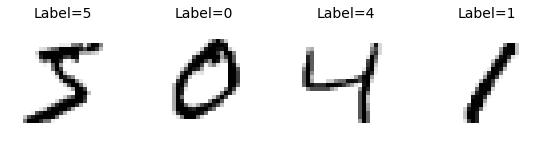

In [ ]:
plt.figure(figsize=(8, 2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

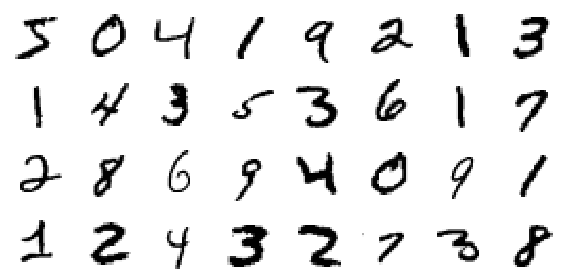

In [ ]:
n_rows = 4
n_cols = 8
plt.figure(figsize=(8, 4))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()

The first character is a 5 digit, encoded in grayscale matrix.

We need to normalize the images and one-hot encode the labels.

In [ ]:
x_train /= 255
x_test /= 255

In [ ]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

### <font color=darkred> Softmax regression for MNIST</font>

Logistic regression can be extended to classify data in more than two groups. Softmax regression provides a model for the probability that an input $x$ is associated with each group.  It is assumed that the probability to belong to the class $k\in\{1,\ldots,M\}$ can be expressed by 
\begin{equation*}
\mathbb{P}(Y = k| X) = \frac{\exp(\langle w_k,X \rangle + b_k)}{\sum_{\ell=1}^{M}\exp(\langle w_\ell,X \rangle + b_\ell)} = p_k(X)\,,
\end{equation*}
where $w_\ell \in \mathbb{R}^d$ and $b_\ell$  are model `weights` and `intercepts` for each class.


To estimate these unknown parameters, a maximum likelihood approach is used as in the logistic regression setting. In this case, the loss function is given by the negative log-likelihood (see also the section on gradient based method).

To train the model weights $W_{k, j}$ and $b_k$ for $k=1, \ldots, 10$ and $j=1, \ldots, 784$, we consider the loss function given by the negative log-likelihood.
For the considered model, the negative log-likelihood of a sample with input $x_i \in \mathbb R^{784}$ and label $y_i \in \{0, 1\}^{10}$, it is given by the cross-entropy between the scores $p_k(x_i)$ and the label $y_i$:
$$
- \sum_{k=1}^{10} y_{i, k} \log(p_k(x_i))
$$
For this first model, we will simply use stochastic gradient descent over small batches of data. It can be done easily with TensorFlow, as it will automatically and efficiently compute the gradient from your graph, then apply an optimization algorithm of your choice to perform the parameters update.

In [ ]:
#define the model

def define_model():
    
    model = Sequential()
# First we need to flatten the data: replace 28 * 28 matrices by flat vectors
# This is always necessary before feeding data to a fully-connected layer (Dense object)
    model.add(Flatten(input_shape=input_shape, name='flatten'))
    model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))
    #compile model
    model.compile(
    # specify the loss as the cross-entropy
        loss=keras.losses.categorical_crossentropy,
    # choose the Adagrad solver, but you can choose others
    
        optimizer=keras.optimizers.Adagrad(),
    # to monitor the accuracy on a testing set along optimization
        metrics=['accuracy'])
    
    return model

In [ ]:
# number of data used for each update of the parameter (each gradient computation)
batch_size = 64
# number of times data are scanned
epochs = 10

model = define_model()

# Run the train
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 2s 28us/step - loss: 0.4952 - acc: 0.8731 - val_loss: 0.3671 - val_acc: 0.9036
Epoch 2/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.3626 - acc: 0.9016 - val_loss: 0.3337 - val_acc: 0.9101
Epoch 3/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.3379 - acc: 0.9078 - val_loss: 0.3190 - val_acc: 0.9131
Epoch 4/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.3249 - acc: 0.9105 - val_loss: 0.3094 - val_acc: 0.9149
Epoch 5/10
60000/60000 [==============================] - 2s 26us/step - loss: 0.3164 - acc: 0.9127 - val_loss: 0.3038 - val_acc: 0.9159
Epoch 6/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.3101 - acc: 0.9138 - val_loss: 0.2991 - val_acc: 0.9170
Epoch 7/10
60000/6000

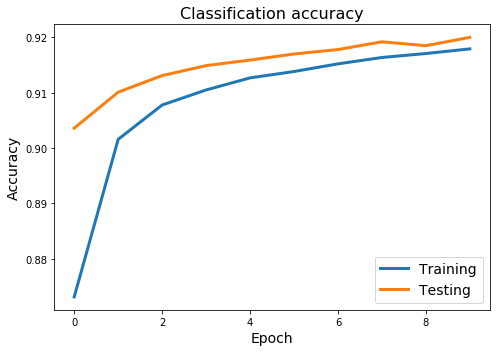

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Classification accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

# Before analyzing the influence of the batch_size and epochs, we going to use randoms values and evaluate our model using K-fold cross validation. After that, we will use gridsearch to look for the best parameters that provide the highest accuracy.

# evaluate using k-fold cross validation

In [ ]:
# evaluate using k-fold cross validation
# Each test set will be 20% of the training dataset. Before splittint the dataset, we shuffle it
#The model will be trained with a batchsize of 32

def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        #define model
        model = define_model()
        # select rows for train and test
        x_train, y_train, x_test, y_test = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), verbose=0)
        # evaluate model
        _, acc = model.evaluate(x_test, y_test, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
        return scores, histories

In [ ]:
evaluate_model(x_train, y_train)


> 91.933


([0.9193333333333333], [<keras.callbacks.History at 0x7effd9a96400>])

Our model achieves more than 90% accuracy. These are good results

In [ ]:

# Let's plot the results
def summarize_diagnostics(histories):
    for i in range(len(histories)):
         # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        print(' ')
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['acc'], color='blue', label='train')
        plt.plot(histories[i].history['val_acc'], color='orange', label='test')
    plt.show()

> 91.975
 


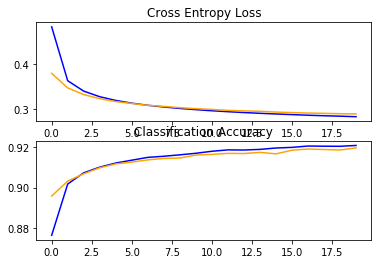

In [ ]:
scores, histories = evaluate_model(x_train, y_train)
summarize_diagnostics(histories)

Our model achives a good fit
There is no obvious signs of over-or underfitting 

In [ ]:
print (np.mean(scores) * 100)

91.975


**Question**

Run a cross-validation to analyze the influence of the number of epochs and the batch-size.

# In the K-fold cross validation, we used a random value batch_size(32) and epoch(20). We were lucky the values chosen achieve a good fit. Now we will choose a set of parameters to train our model in order to find the parameters that provide us with the highest accuracy

# Cross Validation With Parameter Tuning Using Grid Search

In [ ]:
#create a dictionary of all the parameters and their corresponding set of values that you want to test for best performance. 
estimator = KerasClassifier(build_fn=define_model)
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [20, 30],
}

#The grid search will try all combinations of parameter values 
#and select the set of parameters which provides the most accurate model

gr_sr = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
)
gr_sr.fit(x_train, y_train)

Epoch 1/30
60000/60000 [==============================] - 5s 77us/step - loss: 0.4446 - acc: 0.8841
Epoch 2/30
60000/60000 [==============================] - 4s 74us/step - loss: 0.3471 - acc: 0.9052
Epoch 3/30
60000/60000 [==============================] - 4s 74us/step - loss: 0.3277 - acc: 0.9098
Epoch 4/30
60000/60000 [==============================] - 4s 73us/step - loss: 0.3170 - acc: 0.9125
Epoch 5/30
60000/60000 [==============================] - 4s 73us/step - loss: 0.3098 - acc: 0.9140
Epoch 6/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.3045 - acc: 0.9159
Epoch 7/30
60000/60000 [==============================] - 4s 74us/step - loss: 0.3005 - acc: 0.9170
Epoch 8/30
60000/60000 [==============================] - 4s 74us/step - loss: 0.2971 - acc: 0.9176
Epoch 9/30
60000/60000 [==============================] - 4s 71us/step - loss: 0.2943 - acc: 0.9182
Epoch 10/30
60000/60000 [==============================] - 4s 73us/step - loss: 0.2919 - acc: 0.9184

GridSearchCV(cv=5, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7effda0e8588>,
             iid='deprecated', n_jobs=-1,
             param_grid={'batch_size': [16, 32, 64], 'epochs': [20, 30]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# View the best parameters for the model found using grid search
best_parameters =  gr_sr.best_params_
print("The best parameters are")
print(best_parameters)
print("The best score")
print(gr_sr.best_score_)
print()


The best parameters are
{'batch_size': 16, 'epochs': 30}
The best score
0.9182833333333333



In [ ]:
#We going to use the set of parameters found with gridsearch and try them to our model

model = define_model()
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 5s 85us/step - loss: 0.4423 - acc: 0.8839 - val_loss: 0.3458 - val_acc: 0.9070
Epoch 2/30
60000/60000 [==============================] - 5s 80us/step - loss: 0.3461 - acc: 0.9057 - val_loss: 0.3213 - val_acc: 0.9121
Epoch 3/30
60000/60000 [==============================] - 5s 79us/step - loss: 0.3268 - acc: 0.9103 - val_loss: 0.3091 - val_acc: 0.9150
Epoch 4/30
60000/60000 [==============================] - 5s 82us/step - loss: 0.3163 - acc: 0.9126 - val_loss: 0.3032 - val_acc: 0.9156
Epoch 5/30
60000/60000 [==============================] - 5s 81us/step - loss: 0.3093 - acc: 0.9146 - val_loss: 0.2973 - val_acc: 0.9178
Epoch 6/30
60000/60000 [==============================] - 5s 84us/step - loss: 0.3040 - acc: 0.9158 - val_loss: 0.2938 - val_acc: 0.9184
Epoch 7/30
60000/60000 [==============================] - 5s 85us/step - loss: 0.3000 - acc: 0.9172 - val_loss: 0.2909 - val_acc

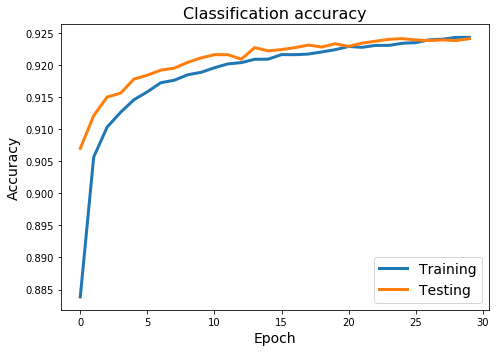

In [ ]:
#Plot the results 
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Classification accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

The accuracy found using the parameters is bigger than the one we had formally ( 0.92 > 0.88). Therefore we can conclude that the number of epochs has a signficant impact on the accuracy. The more epochs we have, the bigger the accuracy will be.

Weight matrices plots show that the learned weights are consistant with the digits they should predict (see below).
You should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc.

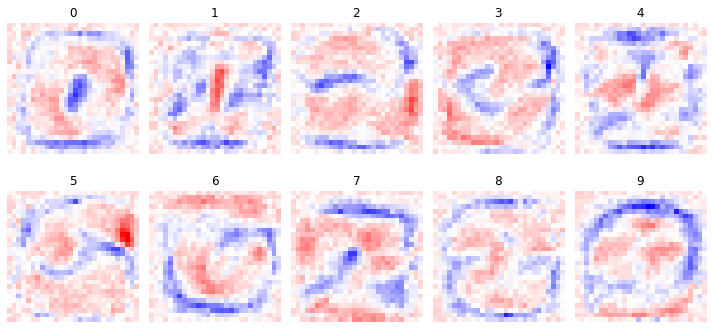

In [ ]:
weights, biases = model.get_layer('dense_softmax').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='bwr')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

### <font color=darkred> Feed-Forward Neural Network (FFNN)</font>

The softmax regression you just trained is a linear model, with 7850 parameters. 
It is easy to fit, numerically stable, but might be too simple for some tasks. 
The idea behind neural networks is to have a nonlinear model, while keeping the nice features of linear ones. 
The idea is to keep parameters into linear functions, and link these small linear model using non linear operations.

A simple nonlinearity which is often used to do this is the rectified linear unit
$\text{ReLU}(x) = \max(0, x)$

The derivative of this function is very easy to compute, and it is parameter-free. If we stack models such as softmax regression and ReLUs, it is still very easy to compute the gradient using the chain rule, as the model is a combination of simple functions.

The backpropagation algorithm allows efficient computation of complex derivatives as long as the function is made of simple blocks with simple derivatives. 
This algorithm efficiency is based on data reuse: when working with parallel architectures such as GPUs, you want to minimize communication (data transfer) as it is very time consuming in comparison to the computing time.

**Question**

Create the graph for a fully connected feed-forward neural network with one hidden layer with 128 units and a relu activation function. 

In [ ]:
#define model

def baseline_model():
    
    model_ffnn = Sequential()

    model_ffnn.add(Flatten(input_shape=input_shape))
###
#To do: add a layer here
    model_ffnn.add(Dense(128, activation='relu'))
###
    model_ffnn.add(Dense(num_classes, activation='softmax'))

    model_ffnn.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adagrad(),
        metrics=['accuracy'])

    return model_ffnn

In [ ]:
batch_size = 32
epochs = 15

model = baseline_model()
# Run the train
history = model.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 6s 98us/step - loss: 0.2593 - acc: 0.9264 - val_loss: 0.1780 - val_acc: 0.9481
Epoch 2/15
60000/60000 [==============================] - 6s 92us/step - loss: 0.1640 - acc: 0.9537 - val_loss: 0.1496 - val_acc: 0.9560
Epoch 3/15
60000/60000 [==============================] - 5s 91us/step - loss: 0.1376 - acc: 0.9613 - val_loss: 0.1318 - val_acc: 0.9613
Epoch 4/15
60000/60000 [==============================] - 6s 99us/step - loss: 0.1219 - acc: 0.9661 - val_loss: 0.1230 - val_acc: 0.9638
Epoch 5/15
60000/60000 [==============================] - 6s 94us/step - loss: 0.1110 - acc: 0.9692 - val_loss: 0.1166 - val_acc: 0.9667
Epoch 6/15
60000/60000 [==============================] - 6s 93us/step - loss: 0.1024 - acc: 0.9715 - val_loss: 0.1098 - val_acc: 0.9674
Epoch 7/15
60000/60000 [==============================] - 5s 89us/step - loss: 0.0956 - acc: 0.9736 - val_loss: 0.1053 - val_acc

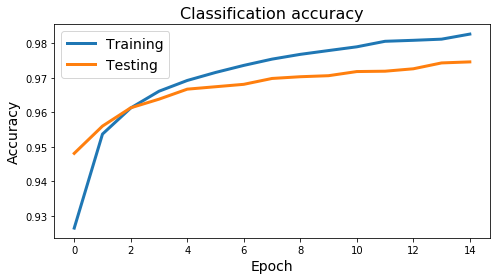

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Classification accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

Our model achives perfect skill
The average accuracy is: 0.97 which is a quite interesting result

**Question**

Run a cross-validation to analyze the influence of the the number of units of the hidden layer, the number of epochs and the batch-size.

#Cross Validation With Parameter Tuning Using Grid Search

In [ ]:
#As we did it 

Epoch 1/30
60000/60000 [==============================] - 14s 228us/step - loss: 0.2560 - acc: 0.9282
Epoch 2/30
60000/60000 [==============================] - 13s 219us/step - loss: 0.1618 - acc: 0.9545
Epoch 3/30
60000/60000 [==============================] - 13s 216us/step - loss: 0.1366 - acc: 0.9615
Epoch 4/30
60000/60000 [==============================] - 13s 215us/step - loss: 0.1214 - acc: 0.9662
Epoch 5/30
60000/60000 [==============================] - 13s 212us/step - loss: 0.1104 - acc: 0.9693
Epoch 6/30
60000/60000 [==============================] - 13s 218us/step - loss: 0.1019 - acc: 0.9718
Epoch 7/30
60000/60000 [==============================] - 13s 217us/step - loss: 0.0952 - acc: 0.9736
Epoch 8/30
60000/60000 [==============================] - 13s 220us/step - loss: 0.0895 - acc: 0.9755
Epoch 9/30
60000/60000 [==============================] - 13s 219us/step - loss: 0.0848 - acc: 0.9771
Epoch 10/30
60000/60000 [==============================] - 13s 220us/step - loss: 

GridSearchCV(cv=5, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5222d9df98>,
             iid='deprecated', n_jobs=-1,
             param_grid={'batch_size': [16, 32, 64], 'epochs': [20, 30],
                         'nb_neuron': [128, 256, 512]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### <font color=darkred> notMNIST</font>

MNIST is a very very **clean** dataset. Digits are rescaled, smoothed, centered, and pixel values are normalized beforehand. Let's switch to a slightly harder dataset: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

This time, labels are letters from 'A' to 'J' (10 classes). 
These letters are taken from digital fonts instead of handwriting pictures. 
We will use a reduced amount of data to ensure a reasonable training time. 
The training set you will use has 200K labelled examples, while the validation and test sets both contain 10K labelled examples.

In [ ]:
import urllib

In [ ]:
pickle_file = './notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    data = pkl.load(f)

In [ ]:
data.keys()

In [ ]:
def reshape(x, image_data_format, img_rows, img_cols):
    if image_data_format == 'channels_first':
        return x.astype(np.float32).reshape((-1, 1, img_rows, img_cols))
    else:
        return x.astype(np.float32).reshape((-1, img_rows, img_cols, 1))

img_rows, img_cols = 28, 28
num_labels = 10
image_data_format = K.image_data_format()

if image_data_format == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
    
x_train = reshape(data['train_dataset'], image_data_format, img_rows, img_cols)
x_valid = reshape(data['valid_dataset'], image_data_format, img_rows, img_cols)
x_test = reshape(data['test_dataset'], image_data_format, img_rows, img_cols)

y_train = keras.utils.to_categorical(data['train_labels'])
y_valid = keras.utils.to_categorical(data['valid_labels'])
y_test = keras.utils.to_categorical(data['test_labels'])

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'training samples')
print(x_valid.shape[0], 'validation samples')
print(x_test.shape[0], 'testing samples')

In [ ]:
# plt.figure(figsize=(8, 4))
n_rows = 10
n_cols = 8
plt.figure(figsize=(n_cols, n_rows))

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def get_label(y):
    return letters[y.argmax()]

for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(get_label(y_train[i]), fontsize=14)
    ax.axis("off")
plt.tight_layout()

**Question**

Train a softmax regression, visualize the weights, plot the convergence curves, save the model and its history (start with a small number of epochs, and increase the number of epochs).

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 43us/step - loss: 0.4869 - acc: 0.8777 - val_loss: 0.3619 - val_acc: 0.9062
Epoch 2/20
60000/60000 [==============================] - 2s 28us/step - loss: 0.3599 - acc: 0.9026 - val_loss: 0.3314 - val_acc: 0.9109
Epoch 3/20
60000/60000 [==============================] - 2s 29us/step - loss: 0.3362 - acc: 0.9081 - val_loss: 0.3160 - val_acc: 0.9137
Epoch 4/20
60000/60000 [============================

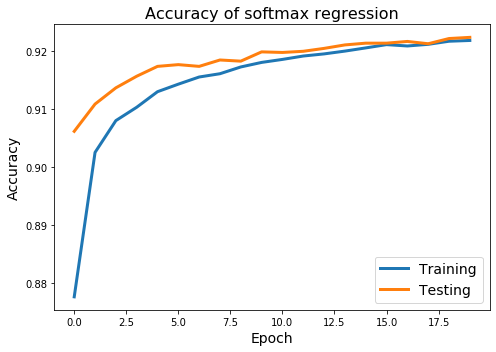

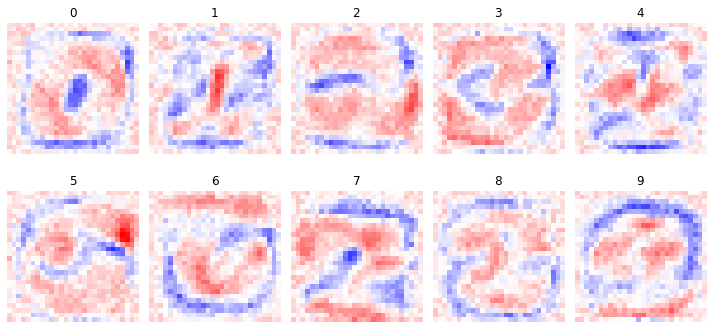

In [ ]:
model_not = Sequential()
model_not.add(Flatten(input_shape=input_shape, name='flatten'))
model_not.add(Dense(num_classes, activation='softmax', name='dense_softmax'))
model_not.compile(
    # specify the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # choose the Adagrad solver, but you can choose others
    optimizer=keras.optimizers.Adagrad(),
    # to monitor the accuracy on a testing set along optimization
    metrics=['accuracy']
)
model_not.summary()

batch_size = 64
epochs = 20
# Run the train
history = model_not.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model_not.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

weights, biases = model_not.get_layer('dense_softmax').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='bwr')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()